In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

from skimage import io, transform
from tensorflow.keras.utils import to_categorical
import time
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/human-vs-nonhuman
/kaggle/input/human-vs-nonhuman/Image_Classification
/kaggle/input/human-vs-nonhuman/Image_Classification/humans
/kaggle/input/human-vs-nonhuman/Image_Classification/archive
/kaggle/input/human-vs-nonhuman/Image_Classification/archive/human-and-non-human
/kaggle/input/human-vs-nonhuman/Image_Classification/archive/human-and-non-human/test_set
/kaggle/input/human-vs-nonhuman/Image_Classification/archive/human-and-non-human/test_set/test_set
/kaggle/input/human-vs-nonhuman/Image_Classification/archive/human-and-non-human/test_set/test_set/humans
/kaggle/input/human-vs-nonhuman/Image_Classification/archive/human-and-non-human/test_set/test_set/non-humans
/kaggle/input/human-vs-nonhuman/Image_Classification/non-humans


In [2]:
#path to images
img_dir = "../input/human-vs-nonhuman/Image_Classification"


#list all available images type
print(os.listdir(img_dir))


['humans', 'archive', 'non-humans']


In [3]:
def load_data(img_dir):
    X = []
    y = []
    labels = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        if folder_name in ("humans","non-humans"):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
                if file_name.endswith('jpg'):
                    im = cv2.imread(f'{img_dir}/{folder_name}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append([idx])
            idx+=1
        
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

X,y,labels = load_data(img_dir)

100%|██████████| 4006/4006 [00:25<00:00, 159.68it/s]


In [4]:
print(labels)

['humans' 'non-humans']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test
train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((6814, 100, 100, 3), (6814, 1), (1203, 100, 100, 3), (1203, 1))

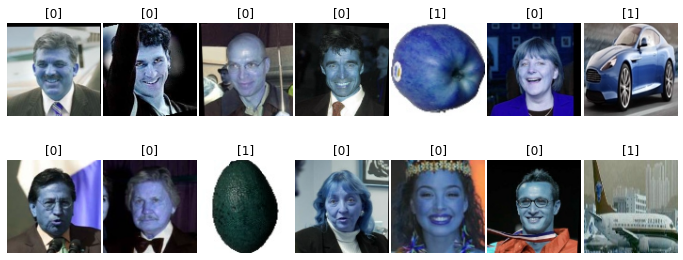

In [7]:
#show random samples
rand_14 = np.random.randint(0, train_img.shape[0],14)
sample_img = train_img[rand_14]
sample_labels = train_labels[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01})
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_img[image_index])
        ax[r,c].set_title('%s' % sample_labels[image_index])
plt.show()
plt.close()

In [8]:
#one-hot-encode the labels
num_classes = len(labels)
train_labels_human = to_categorical(train_labels,num_classes)
test_labels_human = to_categorical(test_labels,num_classes)
train_labels_human.shape, test_labels_human.shape

((6814, 2), (1203, 2))

In [9]:
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((6814, 100, 100, 3), (1203, 100, 100, 3))

In [10]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_human = train_labels_human[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))
print(val_count)

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_human = train_labels_human[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_human2 = train_labels_human[val_count:,:]

train_data2.shape, train_labels_human2.shape, val_data.shape, val_labels_human.shape, test_data.shape, test_labels_human.shape

681


((6133, 100, 100, 3),
 (6133, 2),
 (681, 100, 100, 3),
 (681, 2),
 (1203, 100, 100, 3),
 (1203, 2))

In [11]:
print(val_labels_human)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [12]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']
    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals


In [13]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import numpy as np
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import mnist
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import Image

In [15]:
# Demo data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [16]:
#create multiple cnn model for ensembling
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))



model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2023-01-14 13:54:23.255684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 13:54:23.345809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 13:54:23.346637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 13:54:23.348946: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
FAST_RUN = False

In [18]:
# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# train
epochs = 10
j=0
start_time = time.time()
history = model.fit(datagen.flow(train_data2, train_labels_human2, batch_size=64),epochs = epochs, steps_per_epoch = train_data2.shape[0]/64,validation_data = (val_data, val_labels_human), callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

2023-01-14 13:54:26.515986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-14 13:54:28.699381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


95/95 [==============================] - 25s 172ms/step - loss: 0.4310 - accuracy: 0.8681 - val_loss: 1.8590 - val_accuracy: 0.8282
Epoch 2/10
95/95 [==============================] - 16s 165ms/step - loss: 0.2869 - accuracy: 0.9167 - val_loss: 3.2506 - val_accuracy: 0.5639
Epoch 3/10
95/95 [==============================] - 15s 161ms/step - loss: 0.2141 - accuracy: 0.9320 - val_loss: 0.1947 - val_accuracy: 0.9457
Epoch 4/10
95/95 [==============================] - 16s 165ms/step - loss: 0.2231 - accuracy: 0.9393 - val_loss: 3.4951 - val_accuracy: 0.8003
Epoch 5/10
95/95 [==============================] - 16s 164ms/step - loss: 0.2392 - accuracy: 0.9331 - val_loss: 0.4490 - val_accuracy: 0.9207
Epoch 6/10
95/95 [==============================] - 16s 166ms/step - loss: 0.1291 - accuracy: 0.9563 - val_loss: 0.0677 - val_accuracy: 0.9736
Epoch 7/10
95/95 [==============================] - 15s 161ms/step - loss: 0.1270 - accuracy: 0.9628 - val_loss: 0.1171 - val_accuracy: 0.9780
Epoch 8/10

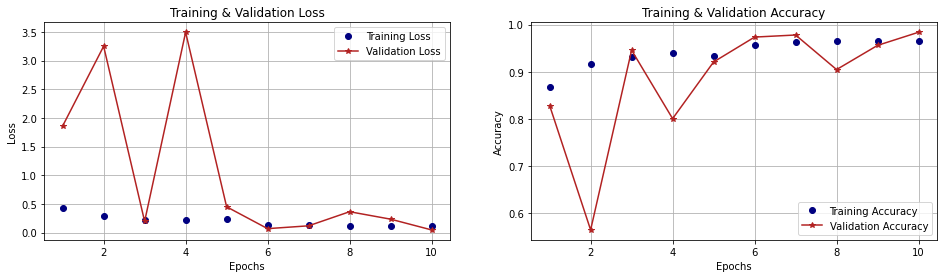

In [19]:
show_plots(history.history)

In [20]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels_human, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

19/19 [==============================] - 1s 27ms/step - loss: 0.0463 - accuracy: 0.9867
Test loss: 0.0463 accuracy: 0.9867


In [21]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_cnn.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_cnn.h5")